In [1]:
import os
import numpy as np
import pandas as pd
import desispec.io
from desispec.coaddition import coadd_cameras
from astropy.io import fits
import h5py
import random

# Combine QSO + LAE (ELG) to lenses

np.random.seed(123)  # Set seed for NumPy's random generator
random.seed(123)  # Set seed for Python's random module


# Function to extract data from HDF5 files
def extract_data_from_hdf5(file_path):
    with h5py.File(file_path, "r") as hdf5_file:
        classifier = hdf5_file["classifier"][:].astype(str)
        name = hdf5_file["name"][:].astype(str)
        redshift = hdf5_file["redshift"][:]
        intflux = hdf5_file["intflux"][:]
        spectra = hdf5_file["spectrum"][:]
    return classifier, name, redshift, intflux, spectra


# Function to process and modify QSO fluxes
def process_qso_fluxes(fits_directory, hdf5_directory, output_directory, lens_percentage=.1, num_files=None):
    # List all HDF5 files in the directory and sort them by name
    hdf5_files = sorted([f for f in os.listdir(hdf5_directory) if f.endswith(".h5")])

    # Initialize arrays to store data
    all_classifierLAE, all_namesLAE, all_redshiftsLAE, all_intfluxLAE, all_spectraLAE = [], [], [], [], []

    # Iterate over HDF5 files in the directory
    for filename in hdf5_files:
        file_path = os.path.join(hdf5_directory, filename)
        print(f"add LAE spectra {filename}")

        # Extract data from the HDF5 file without filtering
        classifier, name, redshift, intflux, spectra = extract_data_from_hdf5(file_path)

        # Append the data to the respective arrays
        all_classifierLAE.extend(classifier)
        all_namesLAE.extend(name)
        all_redshiftsLAE.extend(redshift)
        all_intfluxLAE.extend(intflux)
        all_spectraLAE.extend(spectra)

    all_classifierLAE, all_namesLAE, all_redshiftsLAE, all_intfluxLAE, all_spectraLAE = np.array(all_classifierLAE), np.array(all_namesLAE), np.array(all_redshiftsLAE), np.array(all_intfluxLAE), np.array(all_spectraLAE)

    print(f"Total LAE entries: {len(all_redshiftsLAE)}")

    # List all QSO FITS files in the directory
    fits_files = sorted([f for f in os.listdir(fits_directory) if f.endswith(".fits")])

    if num_files is not None:
        fits_files = fits_files[:num_files]

    # Initialize arrays to store aggregated QSO data
    all_qso_fluxes = []
    all_targetids_qso = []
    all_redshifts_qso = []
    all_ivar = []
    file_qso_indices = []

    # Iterate over FITS files to aggregate data
    for fits_file in fits_files:
        file_path = os.path.join(fits_directory, fits_file)

        # Read the stacked spectra
        qsos = desispec.io.read_spectra(file_path)

        # Access the extra catalog data
        extra_catalog = qsos.extra_catalog

        # Extract TARGETID and Z arrays
        targetids_qso = extra_catalog['TARGETID']
        redshifts_qso = extra_catalog['Z']

        # Combine camera spectra for QSOs
        qso_fluxes = []
        qso_ivar = []
        for i2 in range(len(qsos)):
            coadd = coadd_cameras(qsos[i2])
            qso_fluxes.append(coadd.flux['brz'][0])
            qso_ivar.append(coadd.ivar['brz'][0])

        # Append data to the aggregated arrays
        all_qso_fluxes.extend(qso_fluxes)
        all_ivar.extend(qso_ivar)
        all_targetids_qso.extend(targetids_qso)
        all_redshifts_qso.extend(redshifts_qso)
        file_qso_indices.append(len(all_qso_fluxes))

    all_qso_fluxes = np.array(all_qso_fluxes)
    all_ivar = np.array(all_ivar)
    all_targetids_qso = np.array(all_targetids_qso)
    all_redshifts_qso = np.array(all_redshifts_qso)

    print(f"Total QSO entries: {len(all_redshifts_qso)}")

    # Initialize a labels array with zeros
    num_qsos = len(all_qso_fluxes)
    labels = np.zeros(num_qsos, dtype=int)
    LAE_redshifts_for_qsos = np.zeros(num_qsos)
    LAE_intflux_for_qsos = np.zeros(num_qsos)
    LAE_names_for_qsos = np.array([""] * num_qsos, dtype=object)

    # Handling 100% lensing when lens_percentage is 1.0
    if lens_percentage == 1.0:
        valid_qso_indices = np.where(all_redshifts_qso <= 3.0)[0]
        print(f"Number of valid QSOs for lensing: {len(valid_qso_indices)}")
    else:
        # Randomly sample a percentage of the QSOs, regardless of redshift
        num_modify = int(lens_percentage * num_qsos)
        valid_qso_indices = random.sample(range(num_qsos), num_modify)

    # List to keep track of successfully modified indices
    modified_indices = []

    print(np.max(valid_qso_indices))
    print(len(valid_qso_indices))

    # Superimpose LAE fluxes onto QSO fluxes based on the redshift condition
    for i in valid_qso_indices:
        #if i >= len(all_redshiftsLAE):
        #    print(f"QSO index {i} exceeds LAE redshift data size, skipping.")
        #    continue

        elg_candidates = np.where(all_redshiftsLAE > all_redshifts_qso[i])[0]
        if elg_candidates.size > 0:
            elg_idx = random.choice(elg_candidates)
            elg_flux = all_spectraLAE[elg_idx]

            # Generate adjusted_factor from a normal distribution
            while True:
                adjusted_factor = np.random.normal(4, 2)
                if adjusted_factor >= 2 and adjusted_factor <= 4:
                    break

            all_qso_fluxes[i] += elg_flux * adjusted_factor *5
            labels[i] = 1  # Set the label to 1 to indicate modification
            LAE_redshifts_for_qsos[i] = all_redshiftsLAE[elg_idx]
            LAE_intflux_for_qsos[i] = all_intfluxLAE[elg_idx]
            LAE_names_for_qsos[i] = all_namesLAE[elg_idx]
            modified_indices.append(i)

    print(f"Number of modified QSOs: {len(modified_indices)}")

    # Output the modified data into separate files based on the original distribution
    start_idx = 0
    for idx, fits_file in enumerate(fits_files):
        end_idx = file_qso_indices[idx]

        # Create a new HDUList object for the modified data
        hdu_list = fits.HDUList()

        # Create a Primary HDU
        primary_hdu = fits.PrimaryHDU()
        hdu_list.append(primary_hdu)

        # Create a BinaryTableHDU for the modified fluxes
        col1 = fits.Column(name='TARGETID', format='K', array=all_targetids_qso[start_idx:end_idx])
        col2 = fits.Column(name='Z', format='D', array=all_redshifts_qso[start_idx:end_idx])
        col3 = fits.Column(name='FLUX', format='QD()', array=all_qso_fluxes[start_idx:end_idx])
        col4 = fits.Column(name='ivar', format='QD()', array=all_ivar[start_idx:end_idx])
        col5 = fits.Column(name='LABEL', format='I', array=labels[start_idx:end_idx])  # Add labels column
        col6 = fits.Column(name='ELG_Z', format='D', array=LAE_redshifts_for_qsos[start_idx:end_idx])  # Add ELG redshift column
        col7 = fits.Column(name='ELG_NAME', format='A40', array=LAE_names_for_qsos[start_idx:end_idx])  # Add ELG name column
        col8 = fits.Column(name='LAE_intflux', format='D', array=LAE_intflux_for_qsos[start_idx:end_idx])  # Add LAE intflux
        cols = fits.ColDefs([col1, col2, col3, col4, col5, col6, col7, col8])
        hdu = fits.BinTableHDU.from_columns(cols)

        hdu_list.append(hdu)

        # Write to a new FITS file
        output_file_path = os.path.join(output_directory, f"modified_minsignal1_{fits_file}")
        hdu_list.writeto(output_file_path, overwrite=True)

        start_idx = end_idx

    # Output the results
    print("Original QSO fluxes shape:", all_qso_fluxes.shape)
    print("Labels array shape:", labels.shape)
    print("Number of modified fluxes:", np.sum(labels))

    # Ensure the changes are reflected in a new array for further analysis
    resulting_fluxes = all_qso_fluxes


# Example usage
fits_directoryA = os.path.expandvars('$SCRATCH/DATA/MainQSO/A')
hdf5_directoryA = os.path.expandvars('$SCRATCH/DATA/LAE/augLAE_minsignal2_hdf5')
output_directoryA = os.path.expandvars('$SCRATCH/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplified5/A')
# I directly indicate what percentage of the files I want to be lensed and select the number of files
# i want to use from the MainQSO directory (whereever the QSO files are located
process_qso_fluxes(fits_directoryA, hdf5_directoryA, output_directoryA, lens_percentage=.1, num_files=None)


ModuleNotFoundError: No module named 'desispec'

------------------------------------------------------------------------------------------

# Lets try to open a file

In [6]:
import os
import numpy as np
import pandas as pd
from astropy.io import fits
import h5py
import random
import matplotlib.pyplot as plt

In [7]:

# Define the path to the FITS file you want to open
fits_file_path = os.path.expandvars('$SCRATCH/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplified5/A/modified_minsignal2_desi_bright_qso_batch1.fits')

# Open the FITS file
with fits.open(fits_file_path) as hdul:
    # Print the HDU (Header/Data Unit) list
    hdul.info()
    
    # Access the primary HDU
    primary_hdu = hdul[0]
    print("Primary HDU Header:")
    print(primary_hdu.header)
    
    # Access the binary table HDU
    binary_table_hdu = hdul[1]
    data = binary_table_hdu.data

    # Print the column names
    print("\nColumn names in the binary table HDU:")
    print(data.columns.names)
    
    # Access data from columns
    target_ids = data['TARGETID']
    redshifts = data['Z']
    fluxes = data['FLUX']
    labels = data['LABEL']
    elg_redshift = data['ELG_Z']
    lae_intflux = data['LAE_intflux']
    ename = data['ELG_NAME']
    ivar = data['ivar']

    print()
    print(len(labels))
    print(np.sum(labels))
    print(np.sum(labels)/len(labels))

    # Print some example data
    print("\nExample data:")
    print("TARGETID:", target_ids[:20])
    print("Redshifts:", redshifts[:20])
    print("Fluxes:", fluxes[:20])
    print("Labels:", labels[:20])
    print("LAE Redshift:", elg_redshift[:20])
    print("LAE_intflux:", lae_intflux[:20])
    print("LAE name:", ename[:20])

# Output some information about the data
print("\nNumber of entries:", len(data))
print(np.sum(labels))

Filename: /pscratch/sd/j/jspiller/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplified5/A/modified_minsignal2_desi_bright_qso_batch1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     24   12295R x 8C   [K, D, QD(7781), QD(7781), I, D, 40A, D]   
Primary HDU Header:
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                             


Example data:
TARGETID: 39627785483846706
Redshift: 2.770877011006414
Fluxes: [-2.17705536  1.5037291   2.98762703 ...  0.41170043  0.36633596
  0.56242537]
ivar [ 0.13393341  0.12694405  0.11603182 ... 15.16424942 18.06939697
 34.0230217 ]
Labels: 1
LAE Redshift: 5.032701120526513
LAE NAME SPHINX_z6_haloid60300_dir_3
LAE intflux 2.2711988300010537



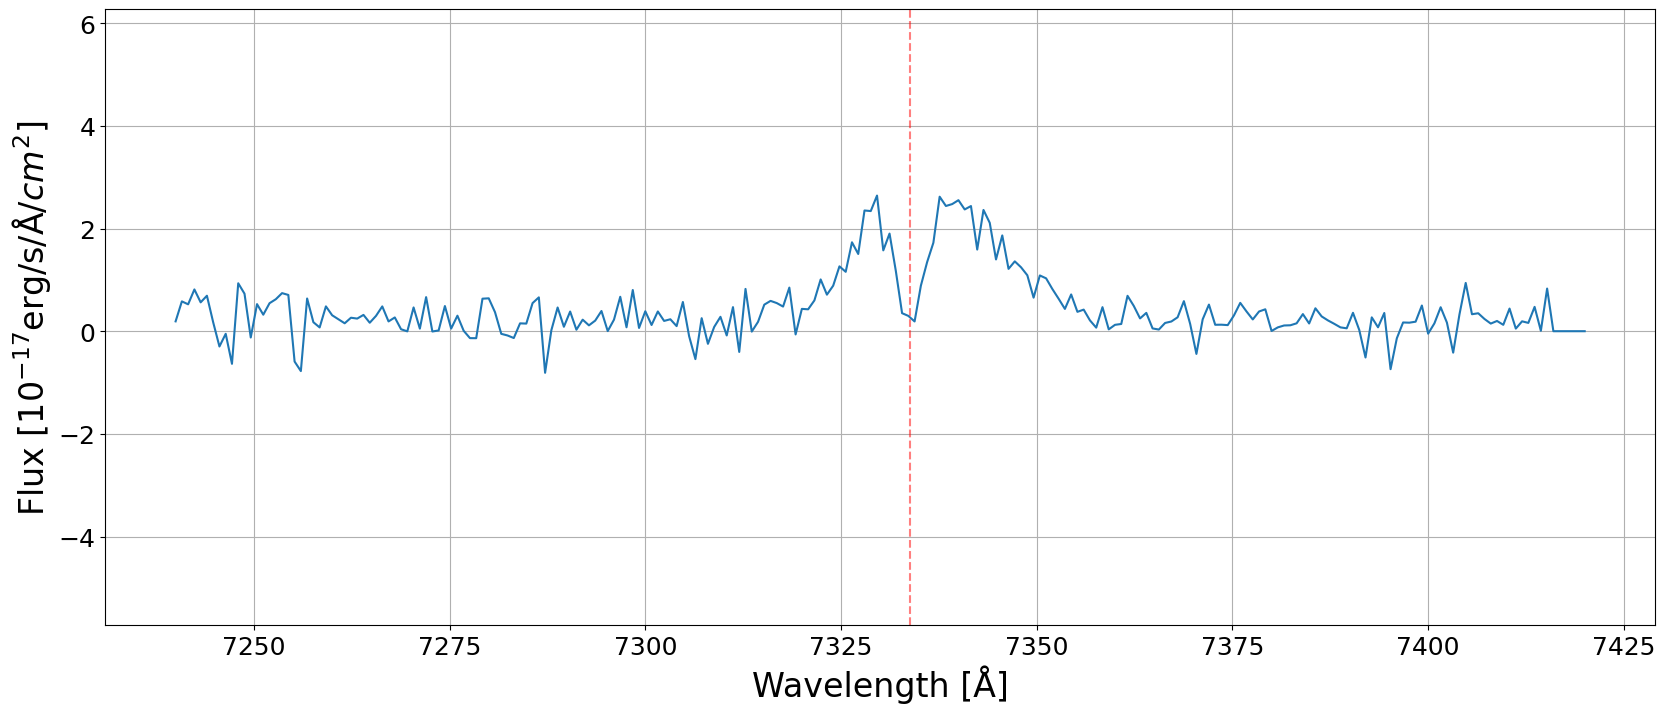


Example data:
TARGETID: 39627791519454413
Redshift: 0.8085623156304389
Fluxes: [2.3794868  3.93179369 5.11740351 ... 0.62924761 0.43517914 0.05459148]
ivar [ 0.14405918  0.1513145   0.14859512 ... 15.04089737 21.06350708
 32.47759628]
Labels: 1
LAE Redshift: 2.465654829112027
LAE NAME ZoomSim_timestep140_direction216
LAE intflux 4.001165141057341



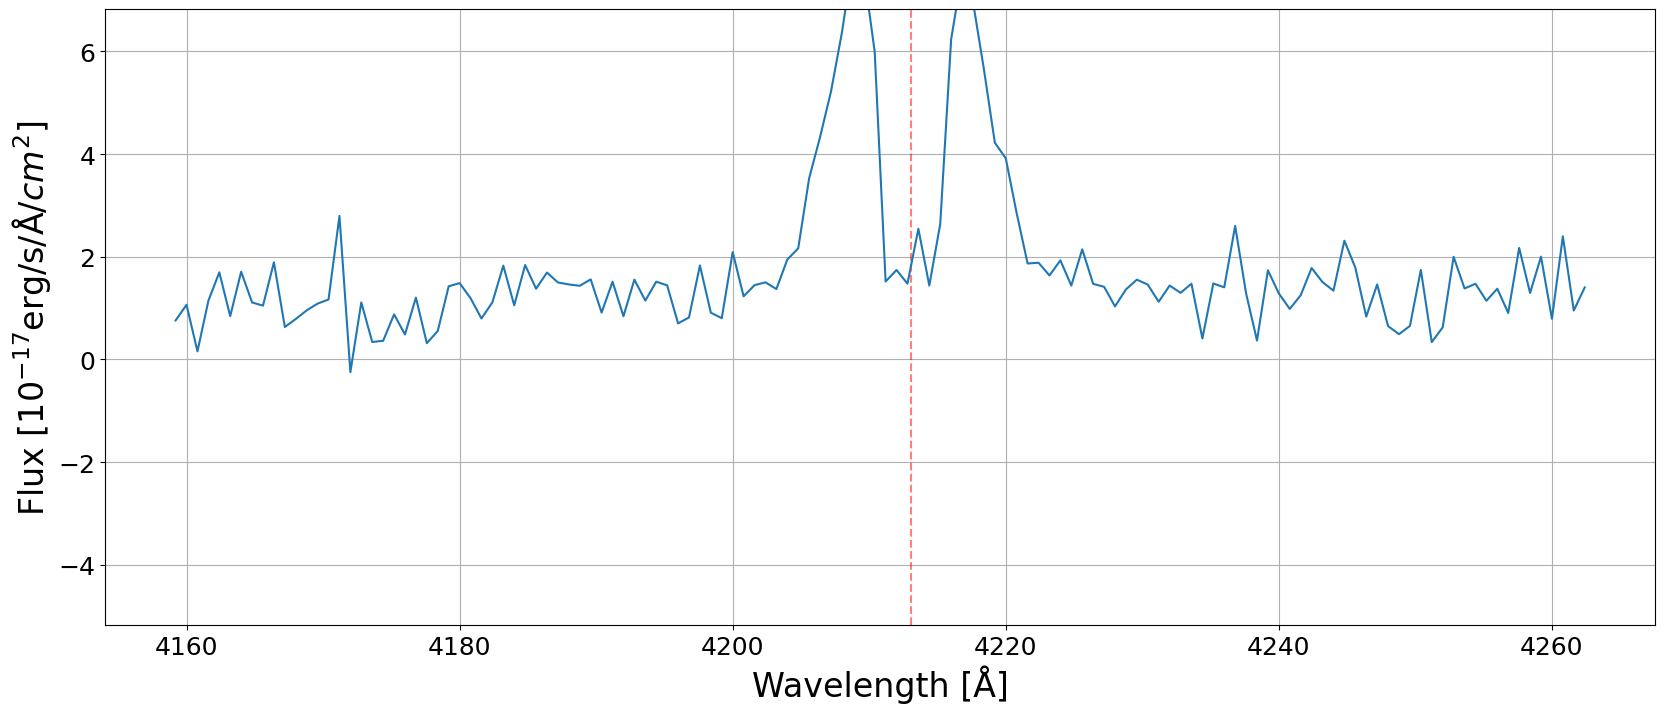


Example data:
TARGETID: 39627791519456288
Redshift: 0.4689205229091383
Fluxes: [6.53689623 5.06240654 3.95094061 ... 0.94481981 1.91378534 1.7022053 ]
ivar [ 0.2209602   0.17508684  0.15133622 ... 15.25878525 14.50065994
 23.33119202]
Labels: 1
LAE Redshift: 4.400885759013406
LAE NAME SPHINX_z4_haloid104508_dir_0
LAE intflux 2.418100985029171



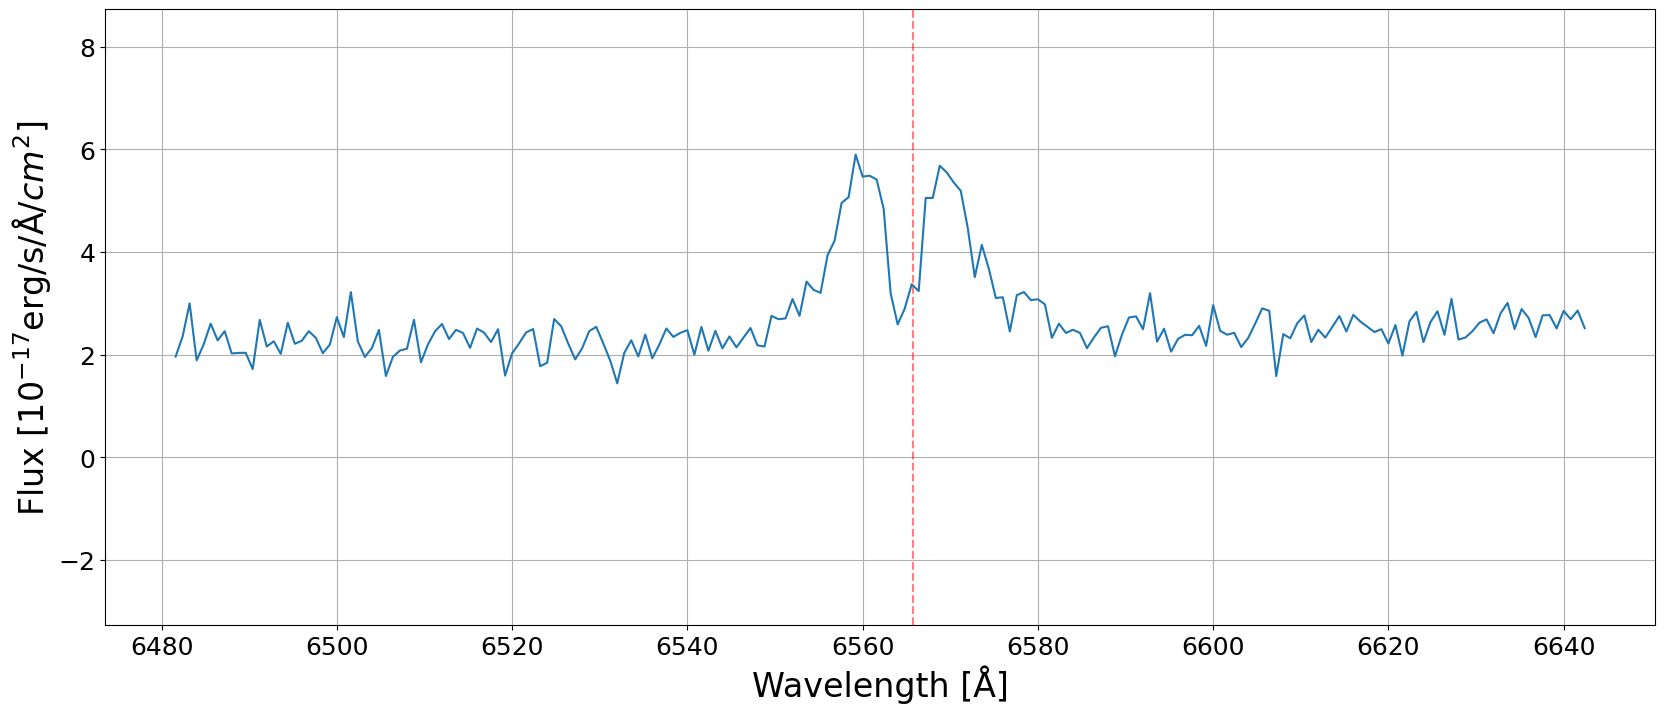


Example data:
TARGETID: 39627791523648314
Redshift: 1.923741577989023
Fluxes: [ 4.99341679 10.76626778  5.2651     ...  0.58600068  0.80710751
  1.20587528]
ivar [ 0.08973603  0.10219023  0.07121491 ... 16.73836327 20.82415009
 23.61335564]
Labels: 1
LAE Redshift: 2.76656743339975
LAE NAME ZoomSim_timestep94_direction169
LAE intflux 2.008616282198728



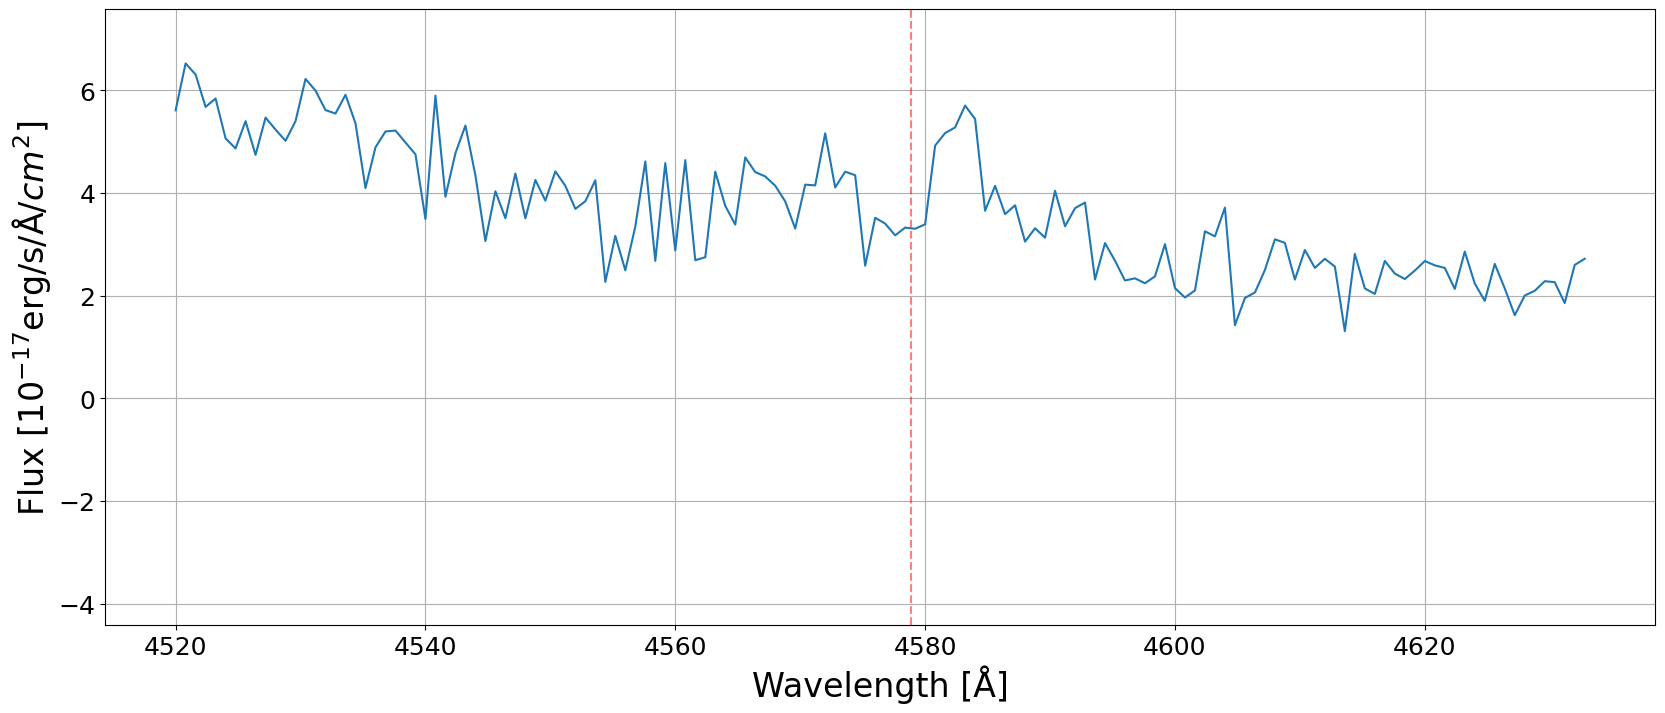


Example data:
TARGETID: 39627791527837903
Redshift: 1.7556950719047177
Fluxes: [3.83236861 3.58639002 1.49007118 ... 1.30822241 0.17368501 0.17234288]
ivar [ 0.14074662  0.11956325  0.11121073 ... 14.79483795 18.36615562
 21.60545731]
Labels: 1
LAE Redshift: 2.3528220489511544
LAE NAME ZoomSim_timestep134_direction118
LAE intflux 2.8343250370626807



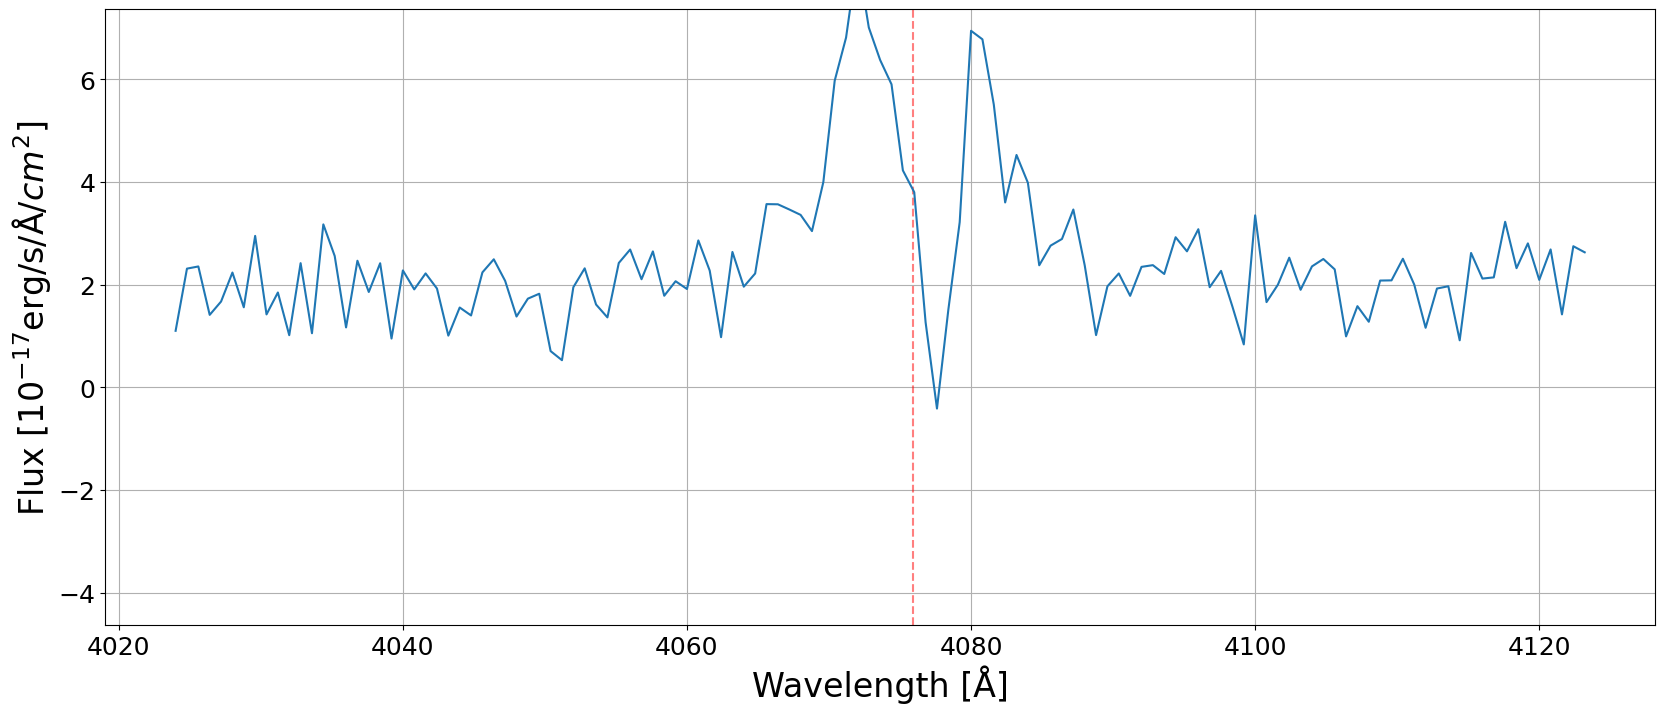


Example data:
TARGETID: 39627791527839027
Redshift: 1.5444556567425594
Fluxes: [ 5.41567373  3.07381129 10.34400272 ...  0.67647195  0.73112118
  0.16623119]
ivar [ 0.13630207  0.13248815  0.0915887  ... 18.45139313 23.68431664
 27.17152214]
Labels: 1
LAE Redshift: 2.499273058775086
LAE NAME ZoomSim_timestep164_direction264
LAE intflux 9.217468449735028



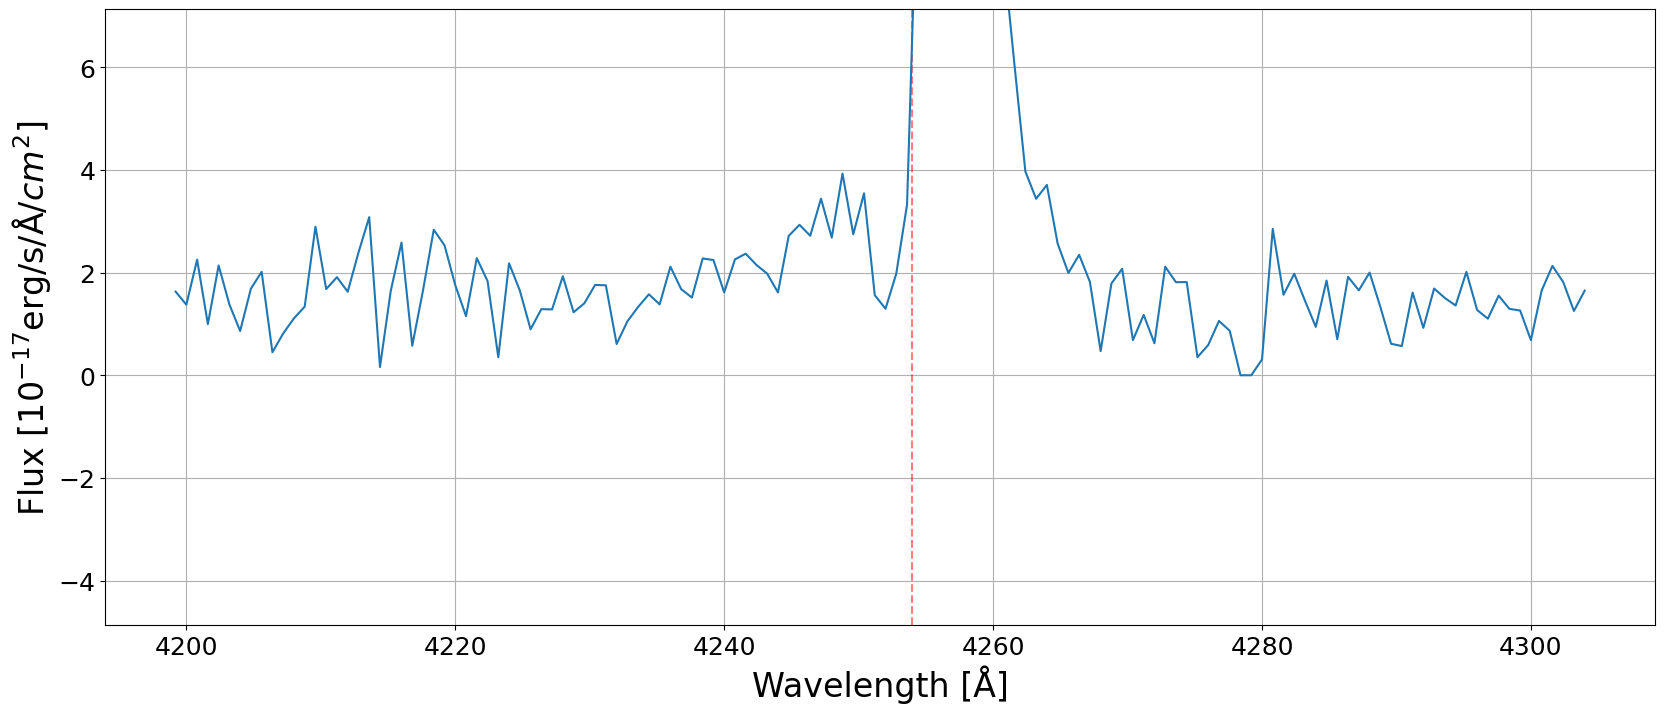


Example data:
TARGETID: 39627797555053756
Redshift: 2.5474784609304257
Fluxes: [-1.14957261 -2.4711504   4.02198839 ...  0.12422527  0.26664415
  0.52900785]
ivar [ 0.23088534  0.20346968  0.19377509 ... 11.33760262 16.63811874
 24.54415703]
Labels: 1
LAE Redshift: 3.3251621075293256
LAE NAME ZoomSim_timestep108_direction159
LAE intflux 2.2834455143866506



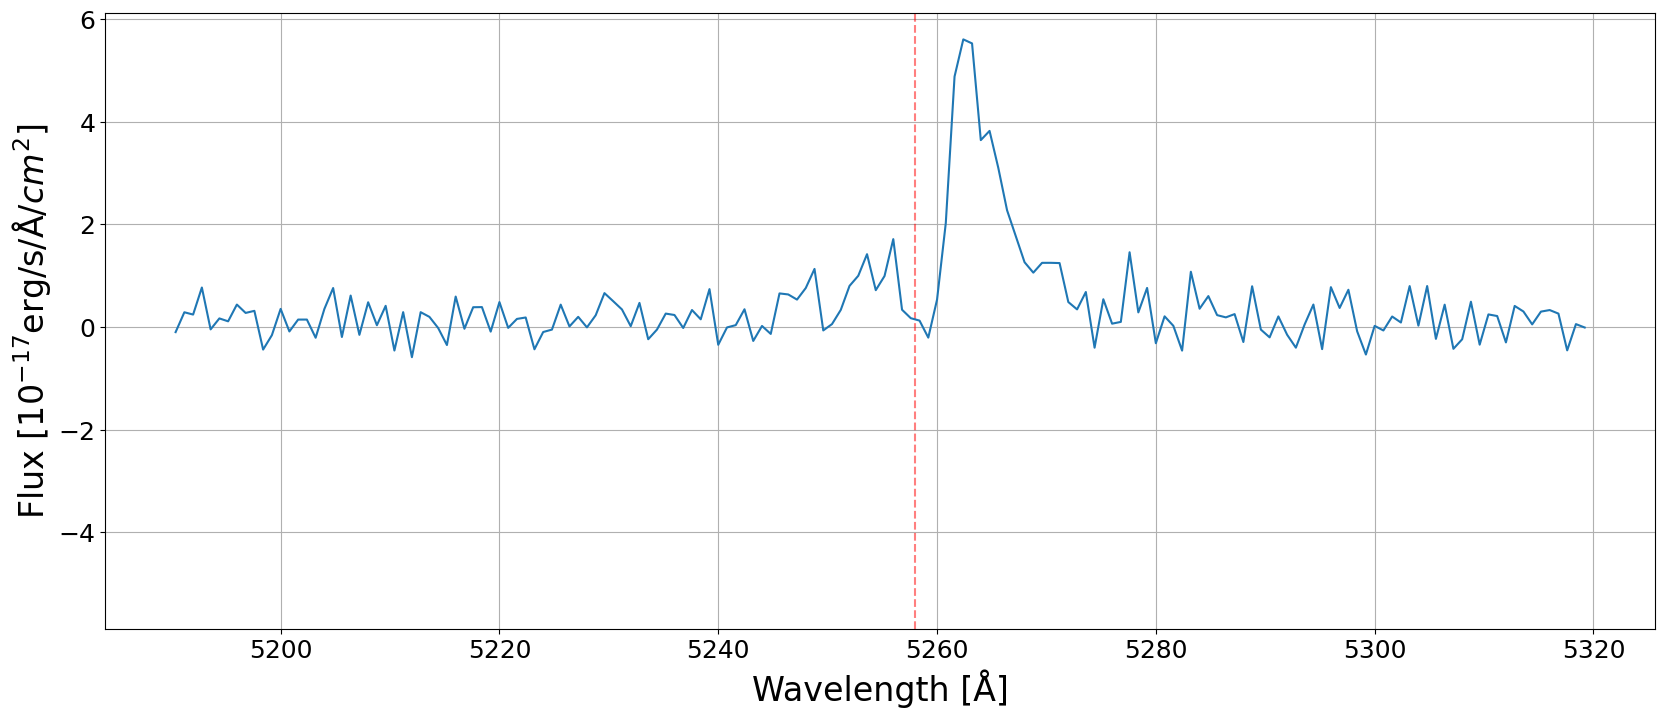


Example data:
TARGETID: 39627797559253129
Redshift: 0.8196028854360476
Fluxes: [16.50656891  5.87143183 11.73661423 ...  2.79289293  2.65089369
  2.89692926]
ivar [ 0.06490617  0.07514945  0.09771185 ... 25.04863739 30.06053543
 31.54161835]
Labels: 1
LAE Redshift: 2.241185695441933
LAE NAME ZoomSim_timestep146_direction122
LAE intflux 2.097135875771921



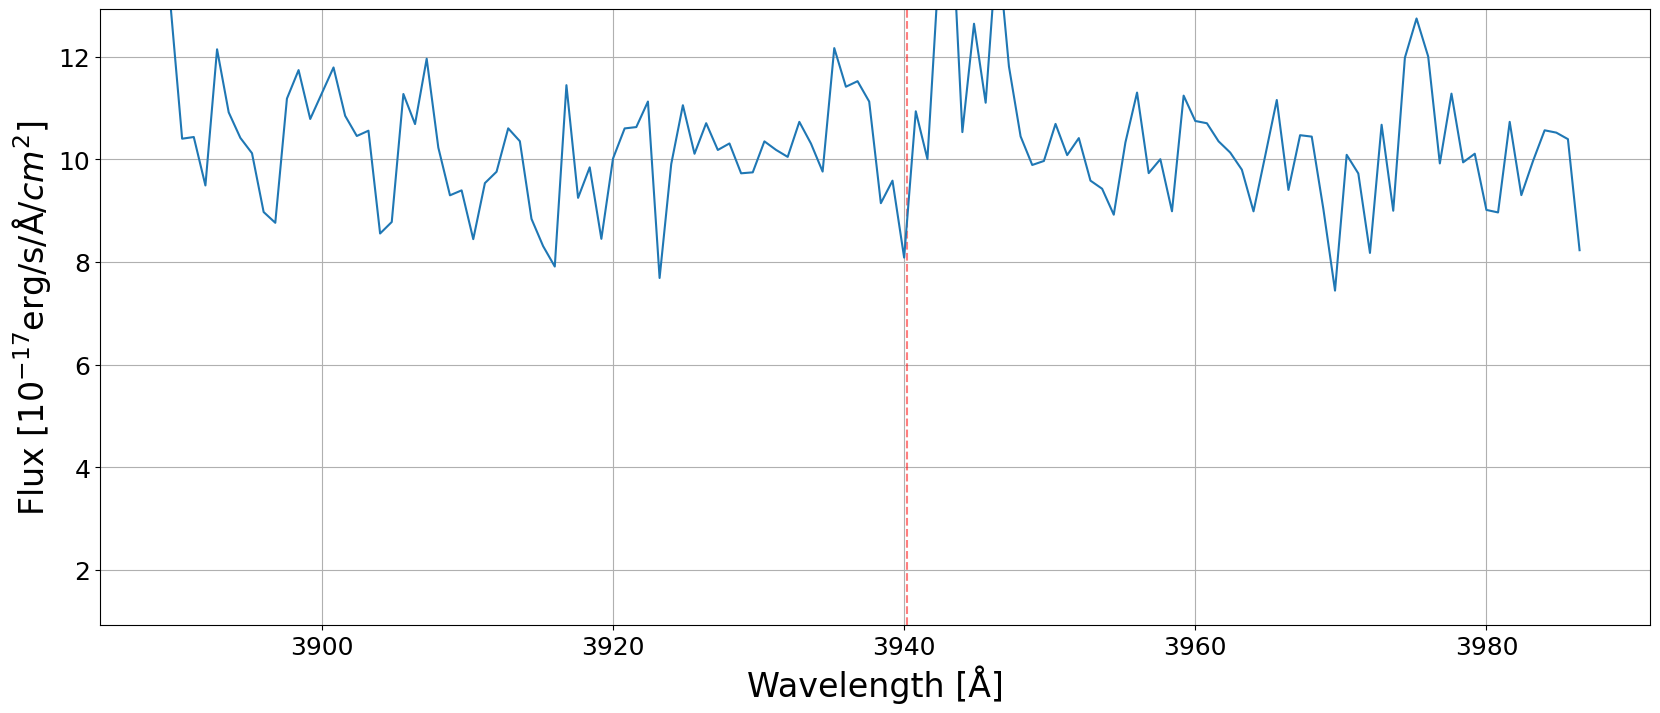


Example data:
TARGETID: 39627797563443063
Redshift: 1.9574090343850767
Fluxes: [ 2.17469025 -0.27073404  0.15702891 ...  0.09823817  0.5213325
  0.30953026]
ivar [ 0.1133582   0.12209407  0.08550873 ... 17.89527512 22.5862751
 35.33942032]
Labels: 1
LAE Redshift: 3.038457815606216
LAE NAME ZoomSim_timestep149_direction15
LAE intflux 2.3684721817023093



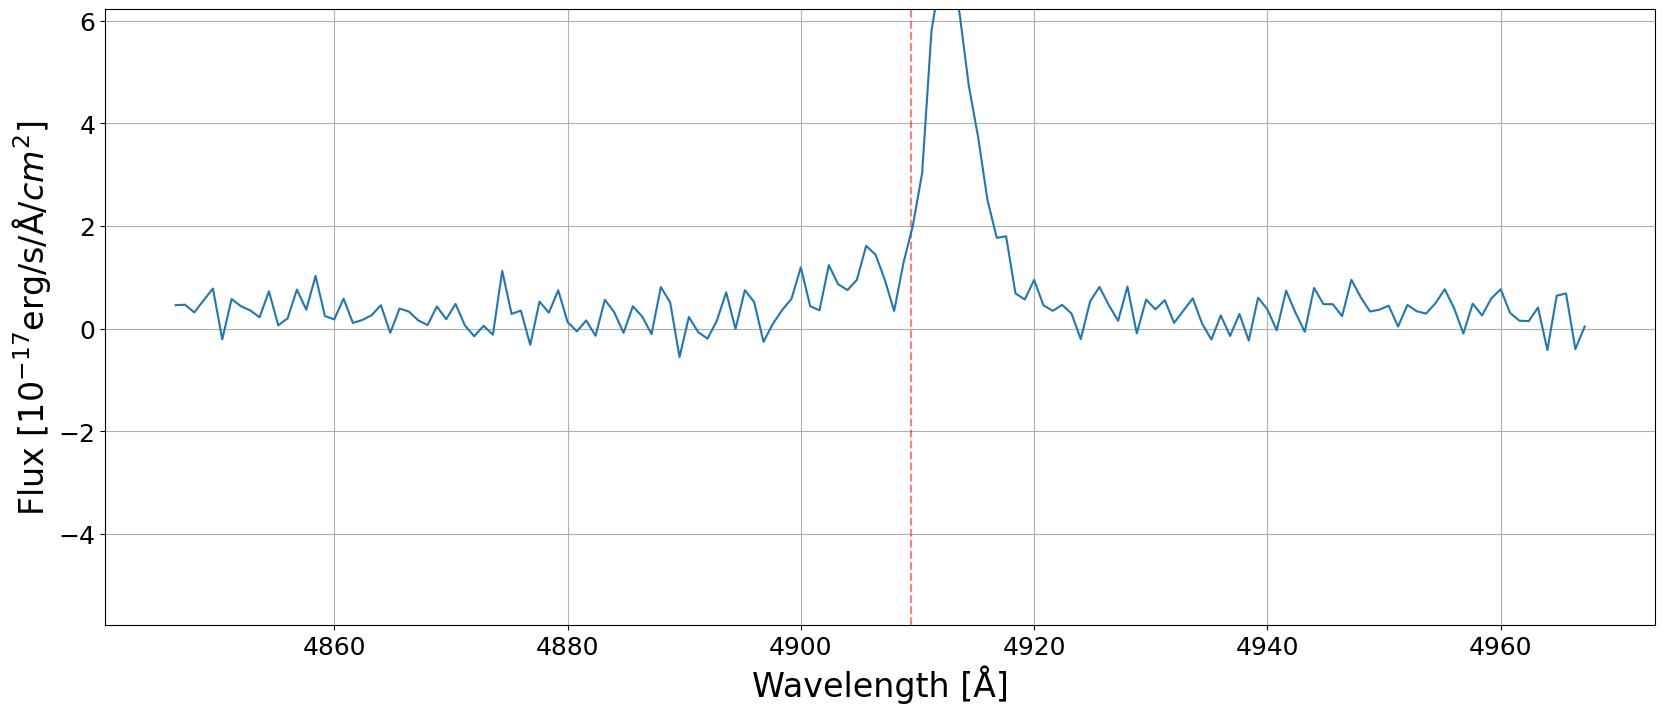


Example data:
TARGETID: 39627797563444498
Redshift: 1.8160443774640955
Fluxes: [-0.39225319 -3.72984433  2.9588232  ...  0.0775028   0.61101598
  0.19045256]
ivar [5.54779954e-02 8.27243030e-02 7.66443759e-02 ... 2.85727482e+01
 5.96363869e+01 9.49760590e+01]
Labels: 1
LAE Redshift: 2.4740251675217397
LAE NAME ZoomSim_timestep160_direction3
LAE intflux 7.07060071051741



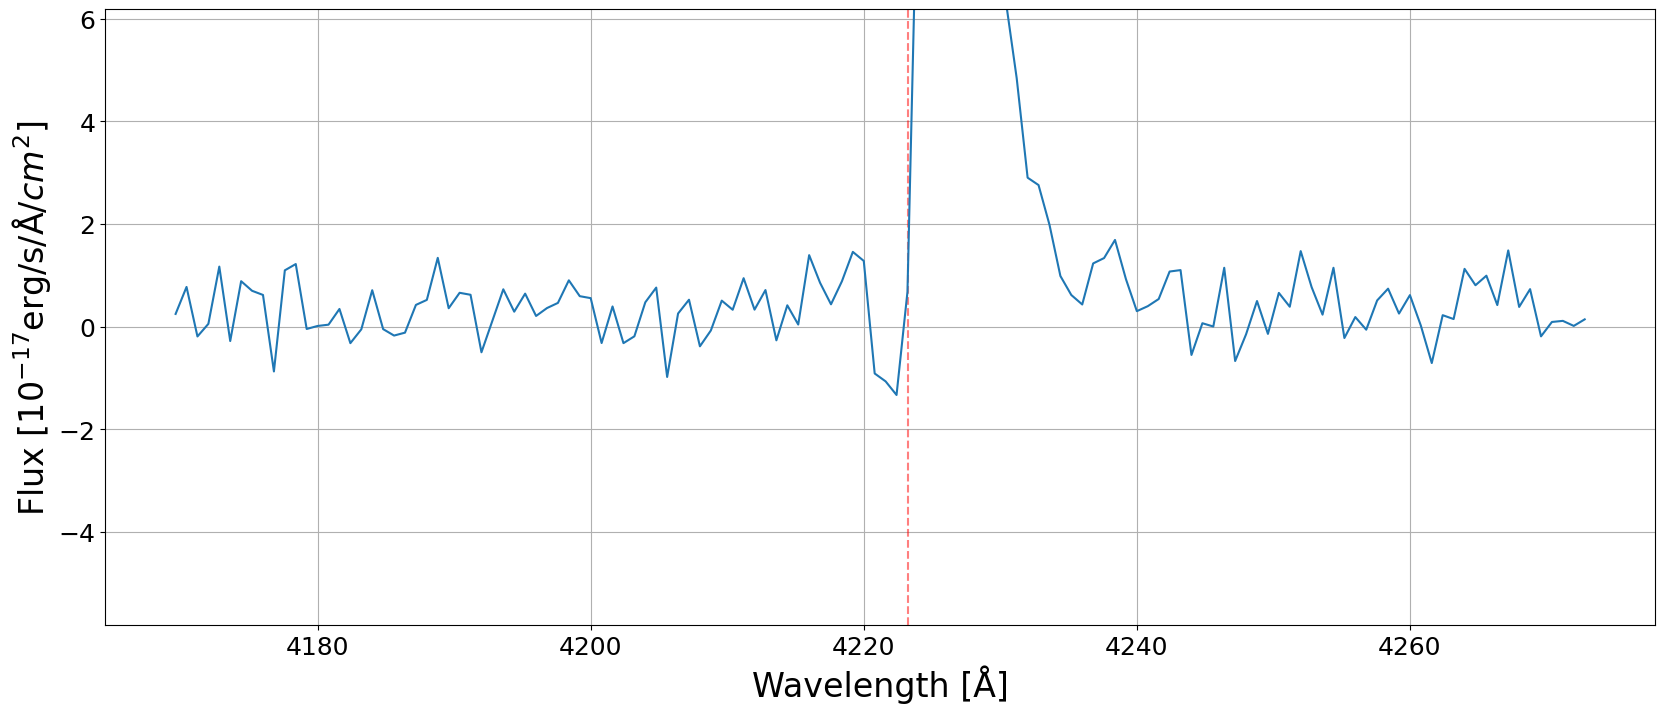


Example data:
TARGETID: 39627797571830402
Redshift: 0.47557447453536483
Fluxes: [-3.24605536  0.03596781 -1.79334712 ...  2.06637645  3.38073897
  1.98382127]
ivar [ 0.09520149  0.07015714  0.07831889 ... 13.96947575 12.49296093
 17.24605942]
Labels: 1
LAE Redshift: 5.006130774848374
LAE NAME SPHINX_z5_haloid475549_dir_2
LAE intflux 3.9650138642284802



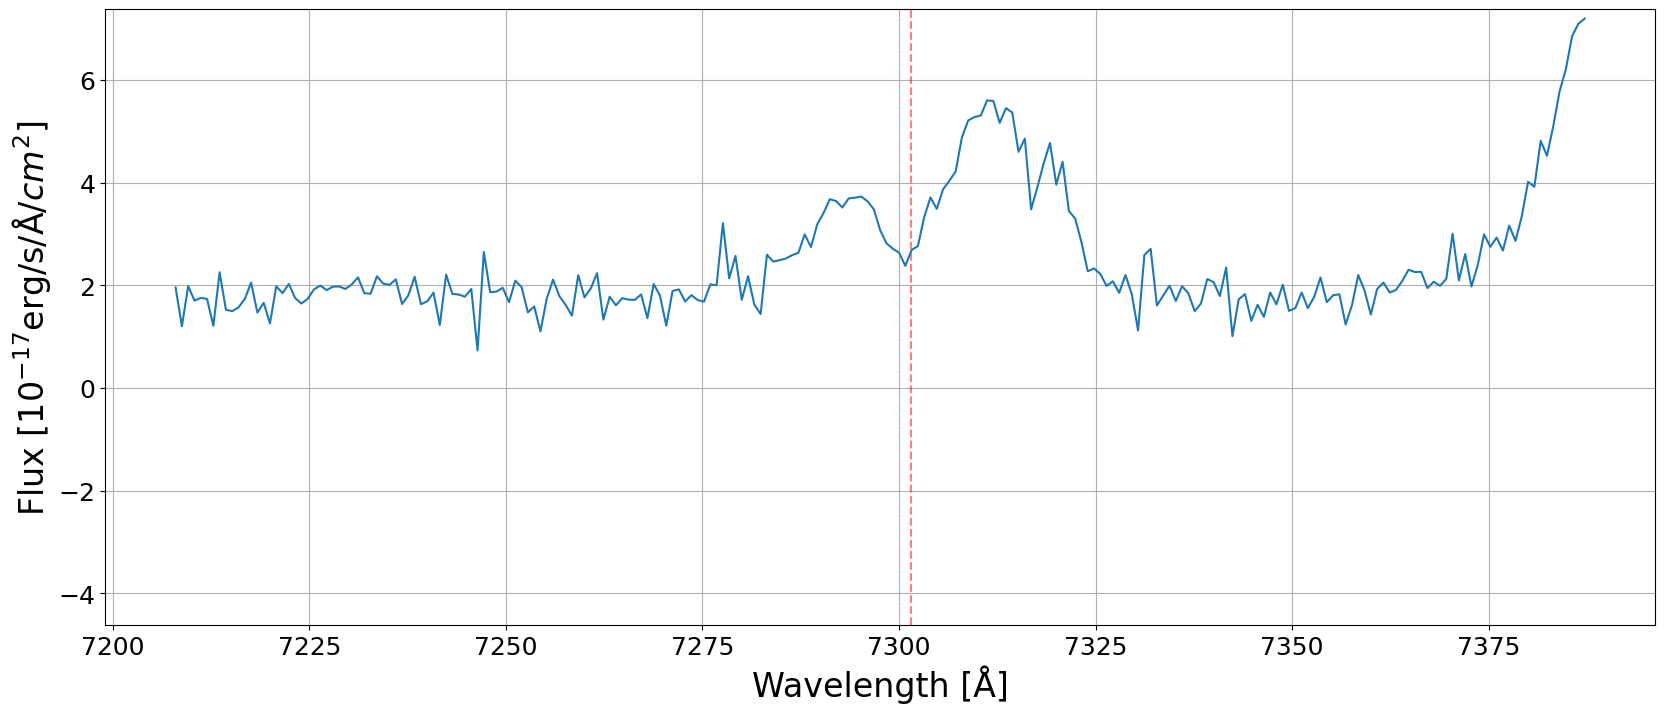


Example data:
TARGETID: 39627797571833366
Redshift: 1.978555255852573
Fluxes: [ 1.15676641  3.37157869 -0.22233123 ... -0.05149069  0.17992558
  0.08909588]
ivar [ 0.12521826  0.13101858  0.08626864 ... 18.24961853 23.22210312
 34.07205963]
Labels: 1
LAE Redshift: 2.6373319971800737
LAE NAME ZoomSim_timestep112_direction233
LAE intflux 3.1276941384273886



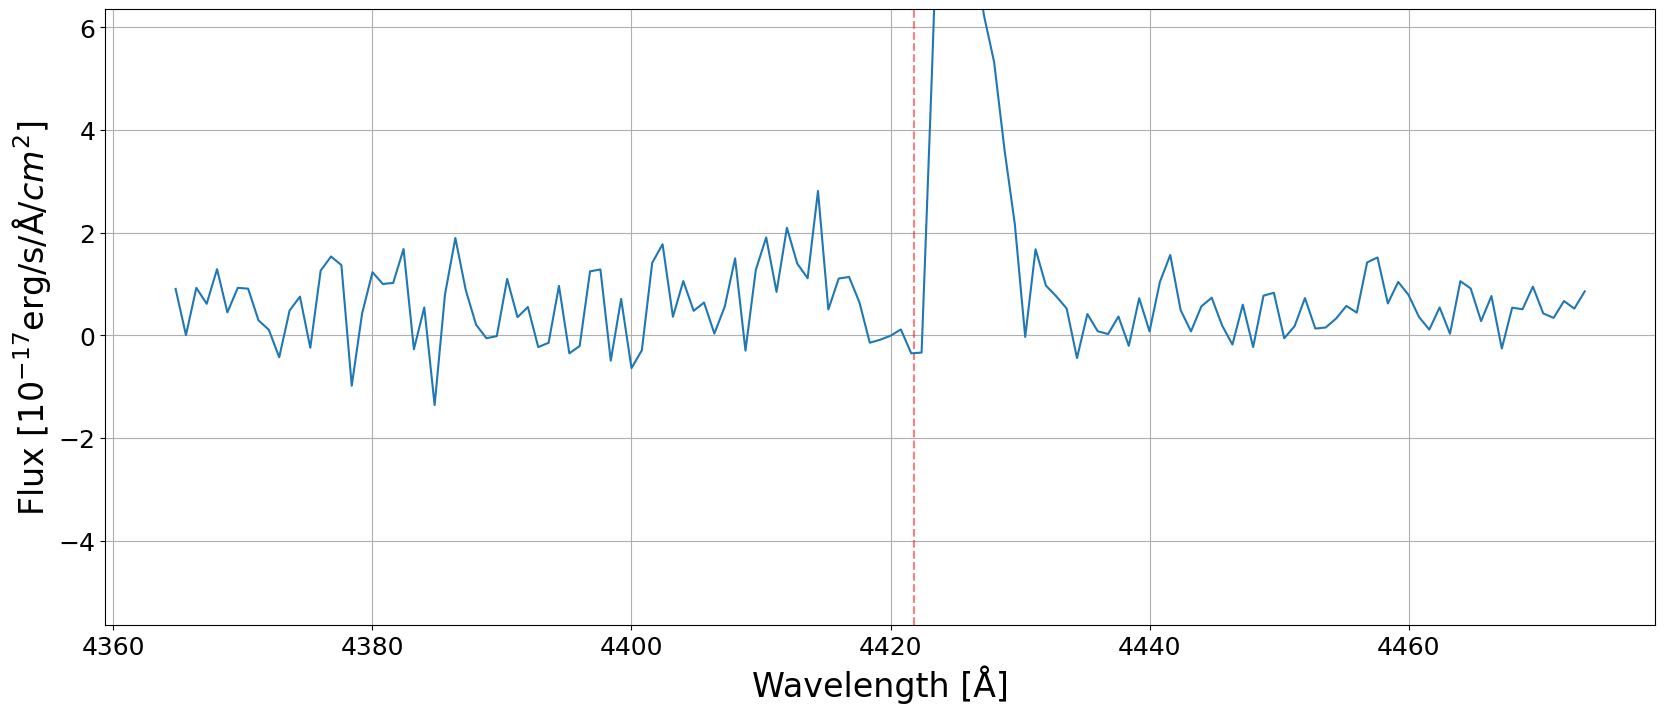


Example data:
TARGETID: 39627803586462890
Redshift: 1.5626715372602142
Fluxes: [-0.56373662  0.76509702  1.76222599 ...  0.15625693  0.12591377
  0.38221702]
ivar [ 0.18586329  0.18970081  0.20908102 ... 30.0222683  60.26121902
 71.193367  ]
Labels: 1
LAE Redshift: 2.6814530401458367
LAE NAME ZoomSim_timestep161_direction15
LAE intflux 2.7534633685719654



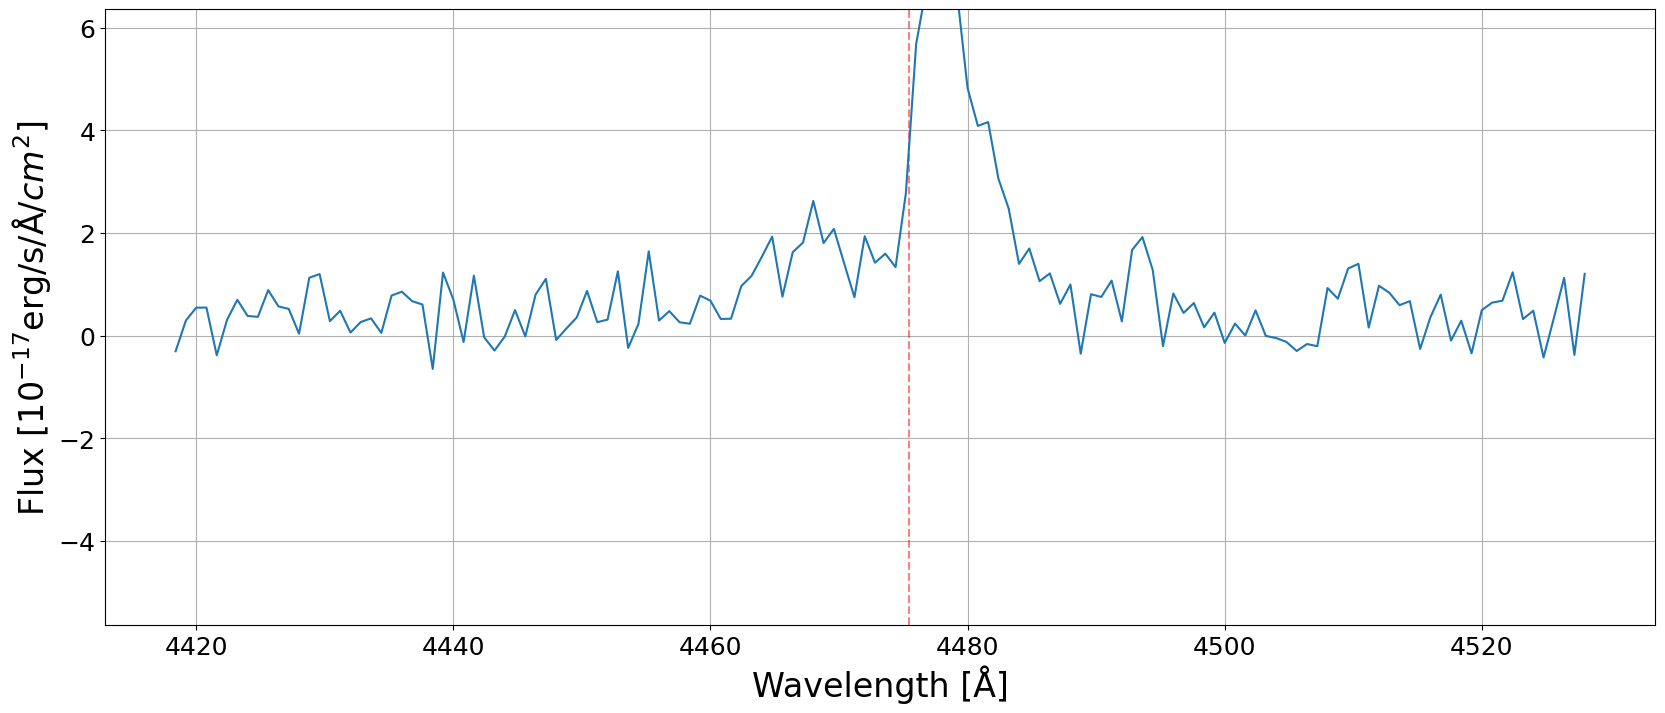


Example data:
TARGETID: 39627803586463448
Redshift: 2.4615456922181544
Fluxes: [1.75509977 2.83746624 1.61077201 ... 1.19729555 0.84057891 1.05618501]
ivar [ 0.32242966  0.31662762  0.35173094 ... 34.00157928 61.91187668
 78.95613098]
Labels: 1
LAE Redshift: 2.5788464986674073
LAE NAME ZoomSim_timestep130_direction78
LAE intflux 3.276470122935918



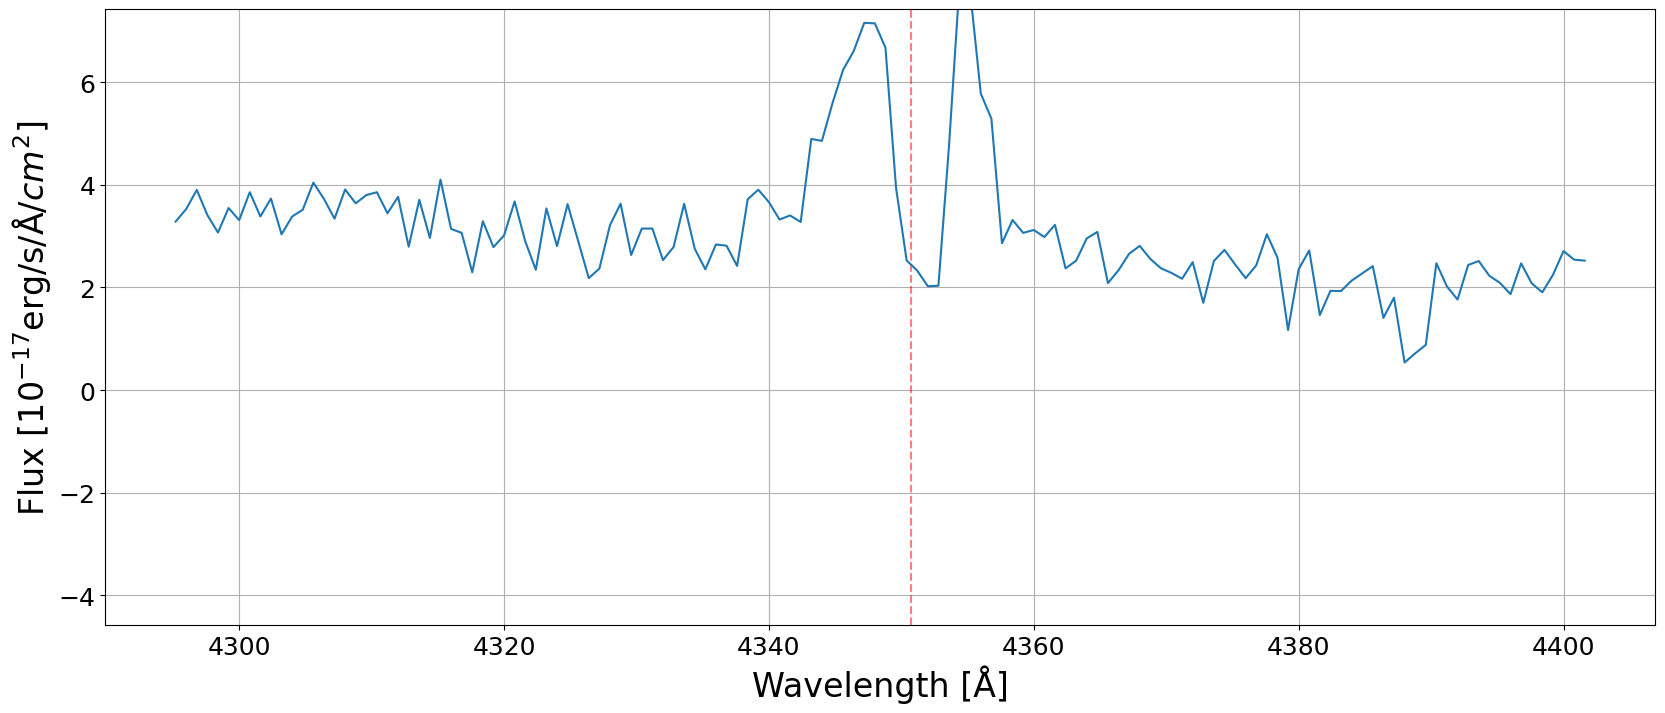


Example data:
TARGETID: 39627803590657057
Redshift: 0.5980764769398973
Fluxes: [0.61277729 4.73929405 3.62936568 ... 0.70905846 0.2068361  0.98533285]
ivar [ 0.1718386   0.18975145  0.20334077 ... 24.39564705 32.61121368
 37.43531799]
Labels: 1
LAE Redshift: 5.50290073557994
LAE NAME SPHINX_z5_haloid196856_dir_5
LAE intflux 3.682381181531903



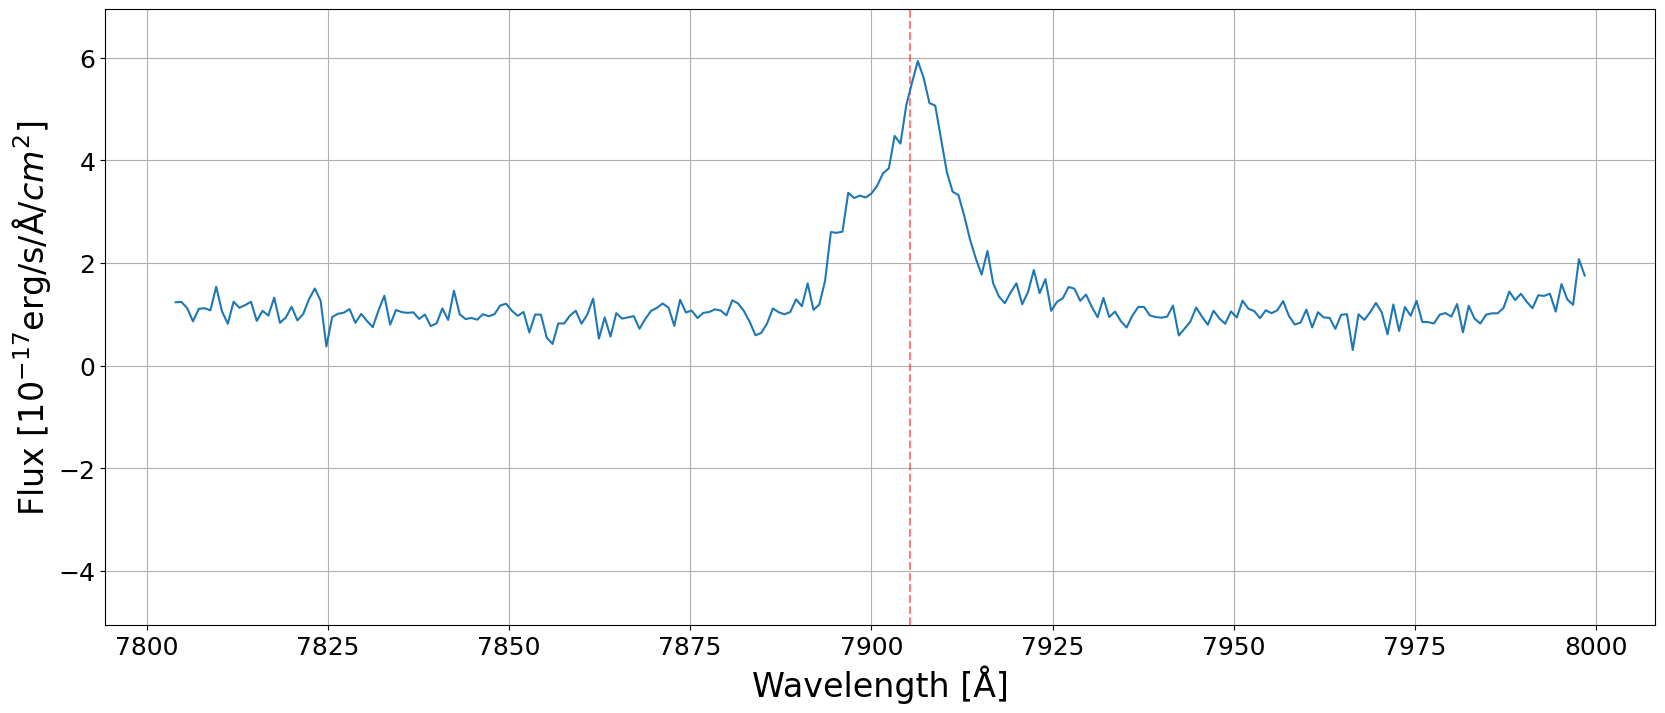


Example data:
TARGETID: 39627803594853310
Redshift: 1.155147116810501
Fluxes: [-6.11809301 -4.51926088  2.97643828 ...  0.10956842 -0.01535045
  0.07799798]
ivar [3.13702971e-02 2.47378685e-02 3.07804532e-02 ... 1.45560188e+01
 2.13536911e+01 3.76268921e+01]
Labels: 1
LAE Redshift: 3.5341594777513468
LAE NAME ZoomSim_timestep112_direction83
LAE intflux 5.408364567744188



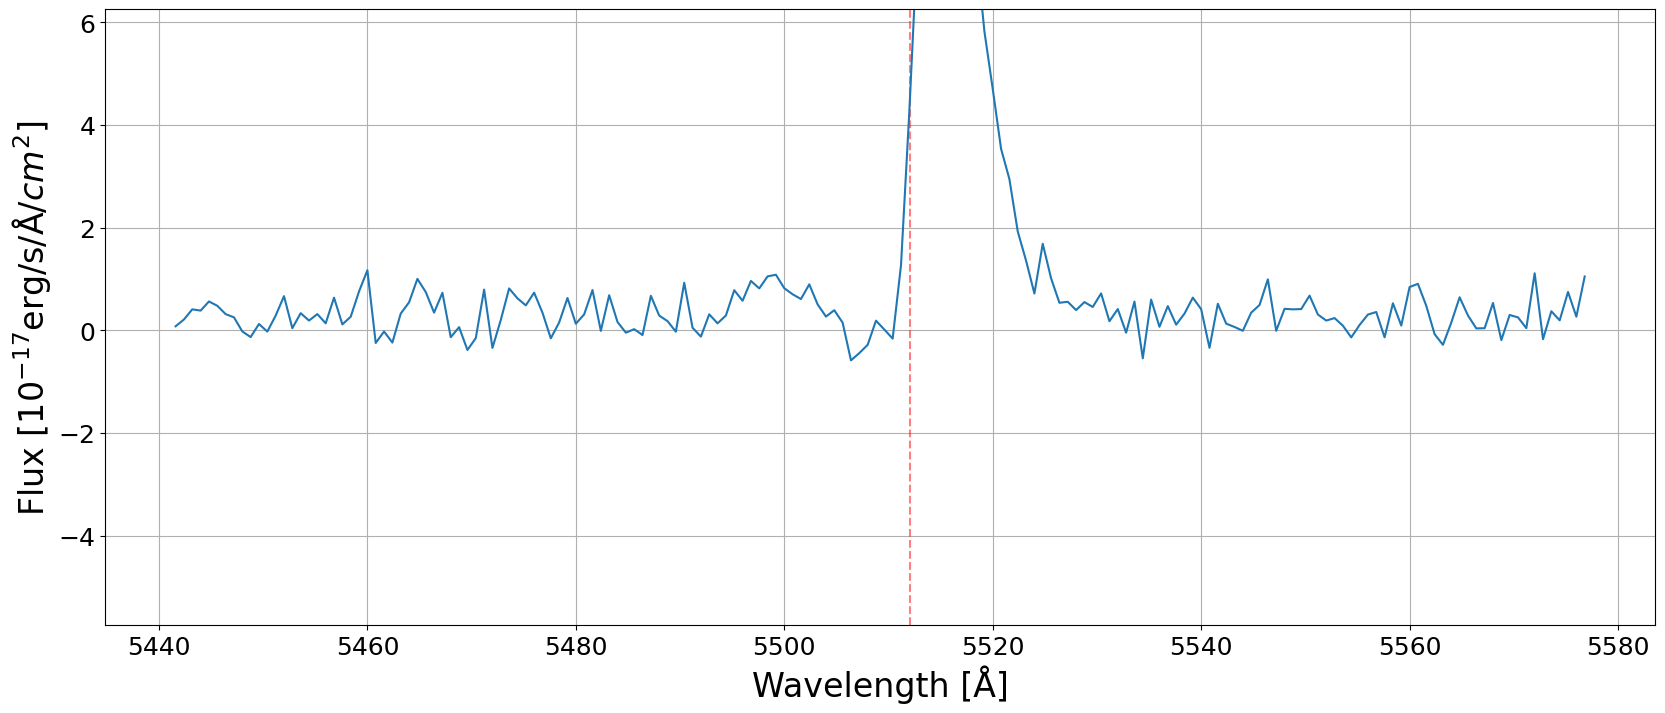


Example data:
TARGETID: 39627803599048297
Redshift: 1.7275163665922089
Fluxes: [-1.5281862  -3.27257586  1.08336031 ...  0.33073547  0.20376578
  0.19302444]
ivar [  0.30938914   0.28634691   0.32945809 ...  48.69263458  79.53858185
 116.77603149]
Labels: 1
LAE Redshift: 2.251503531348452
LAE NAME ZoomSim_timestep90_direction140
LAE intflux 2.9322737717672833



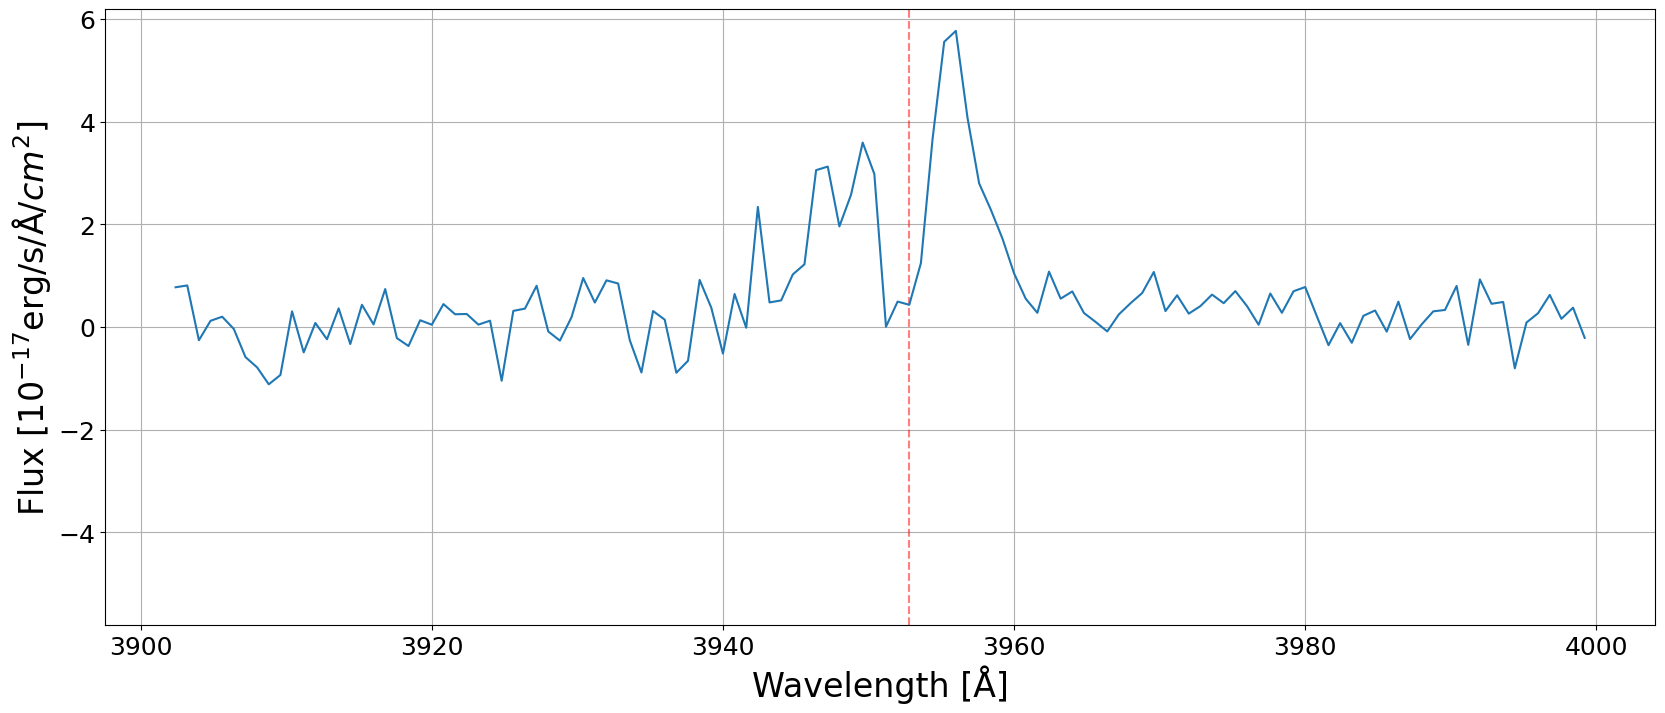


Example data:
TARGETID: 39627803615824737
Redshift: 2.1365695324793617
Fluxes: [-1.12605786  1.23706496 -1.21085215 ...  0.67897135  0.58473551
  0.5787881 ]
ivar [ 0.46579838  0.47803348  0.4434253  ... 31.92115784 40.89222336
 56.91516876]
Labels: 1
LAE Redshift: 4.50851983635676
LAE NAME SPHINX_z4_haloid226145_dir_2
LAE intflux 2.0859881049955398



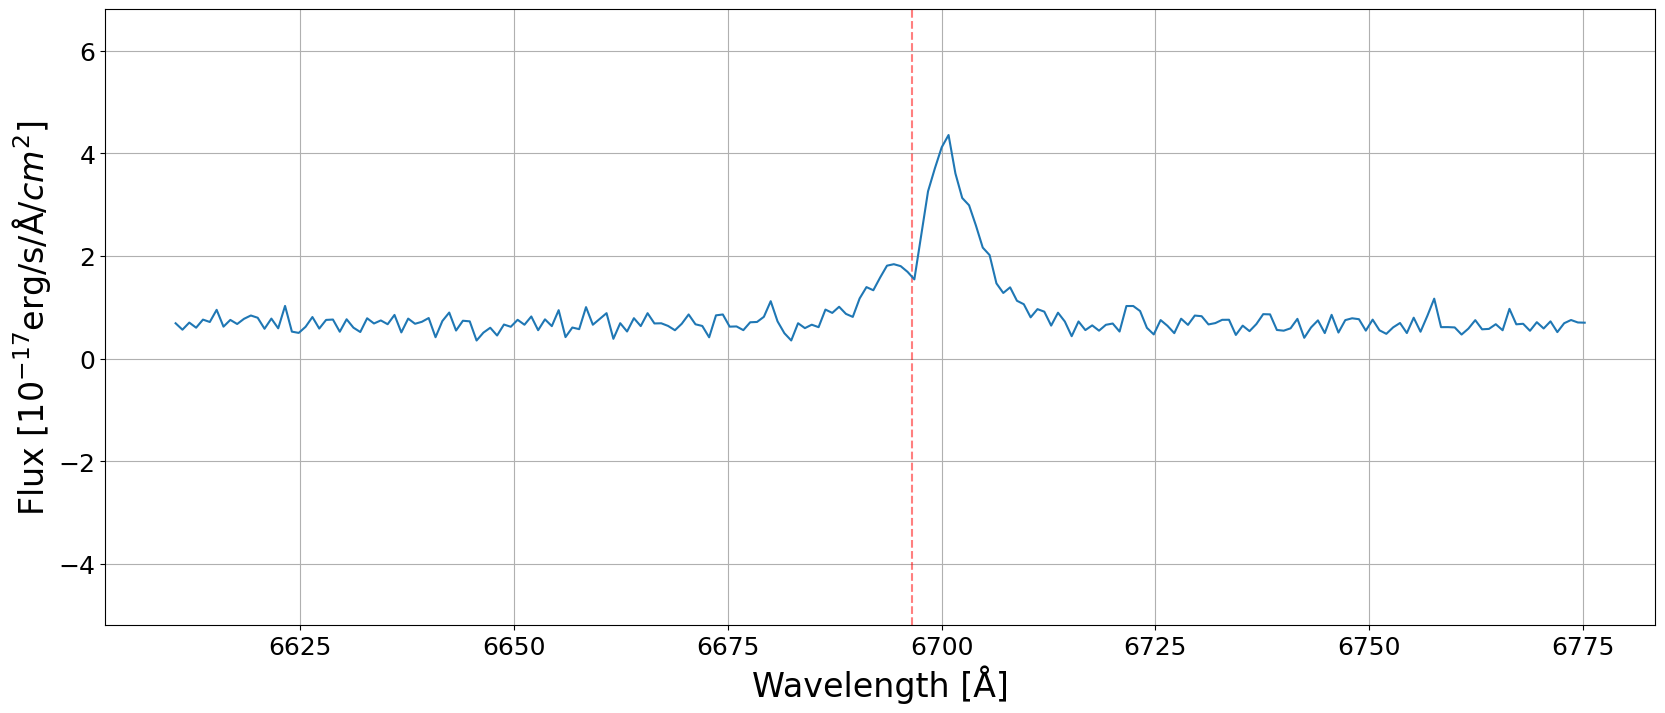


Example data:
TARGETID: 39627809630454486
Redshift: 2.1456232766414614
Fluxes: [-1.99405766  0.00562813  4.75539494 ...  0.29606476  0.09994944
  0.04773131]
ivar [ 0.14089248  0.1170561   0.13152018 ... 12.43947887 18.04545593
 23.08905983]
Labels: 1
LAE Redshift: 5.112861711850232
LAE NAME SPHINX_z6_haloid98263_dir_9
LAE intflux 2.257377047722612



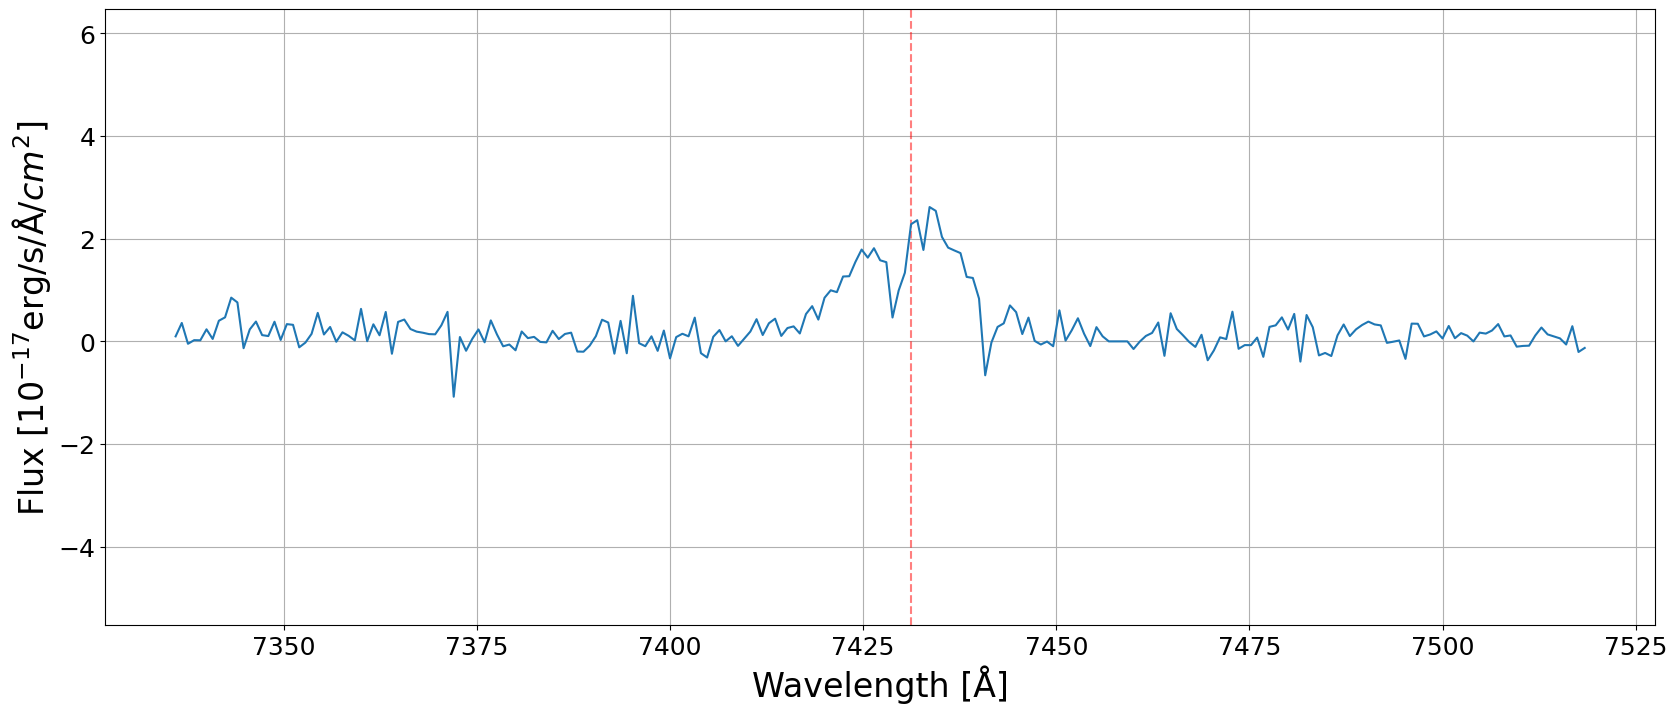


Example data:
TARGETID: 39627809630457635
Redshift: 2.1763465725635482
Fluxes: [-0.27378279 -0.54051477 -7.02087784 ...  0.04697192  0.10721906
 -0.12653325]
ivar [ 0.15730125  0.12309977  0.12742437 ... 12.14839268 16.92845345
 20.41491508]
Labels: 1
LAE Redshift: 3.628087331322593
LAE NAME ZoomSim_timestep94_direction19
LAE intflux 2.295013284020192



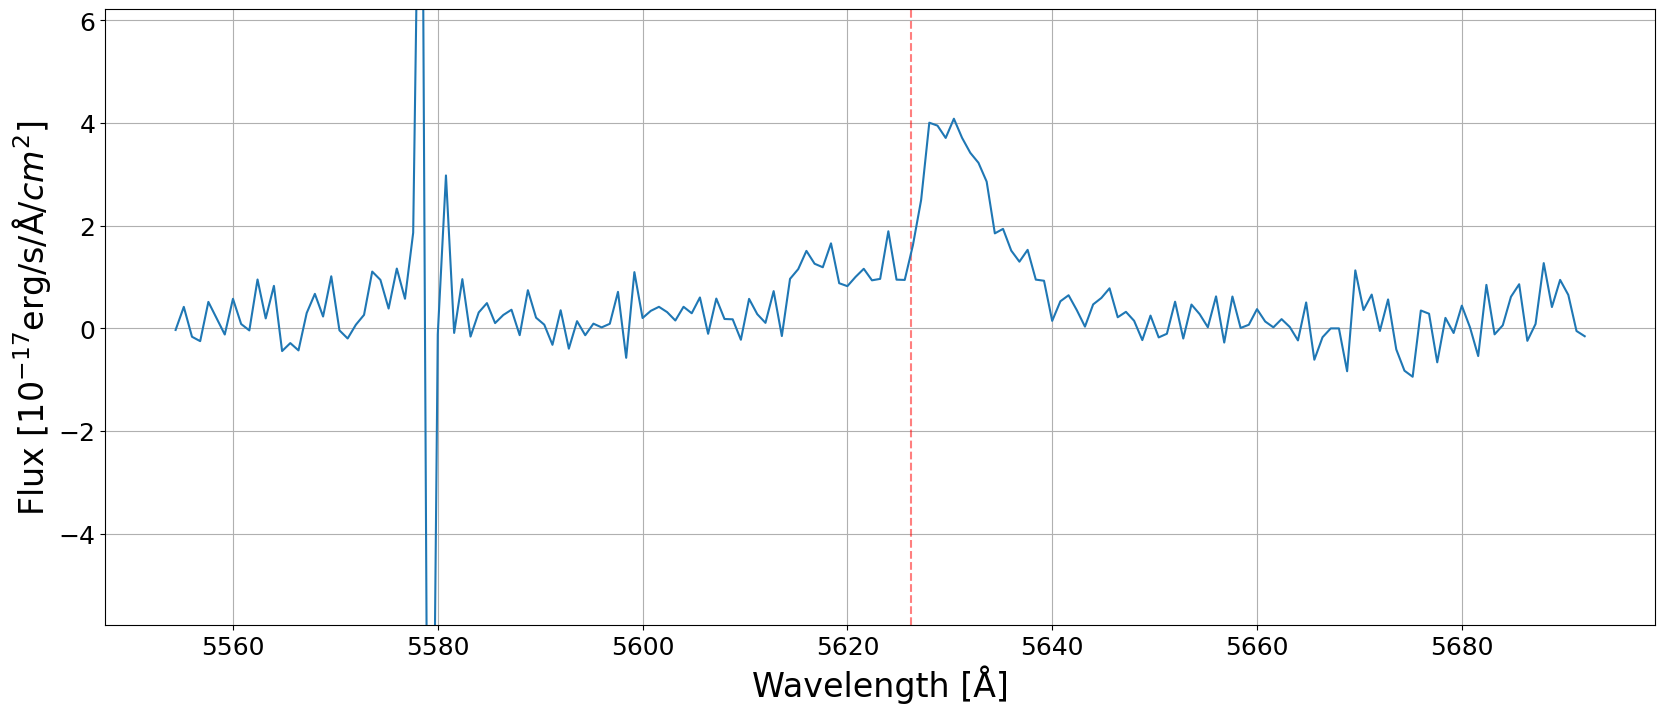

In [9]:
N=20
i=0
n=0

min_wave, max_wave = 1200, 1230
while n<N:
    if labels[i]==1:
        n+=1
        print("\nExample data:")
        print("TARGETID:", target_ids[i])
        print("Redshift:", redshifts[i])
        print("Fluxes:", fluxes[i])
        print("ivar", ivar[i])
        print("Labels:", labels[i])
        print("LAE Redshift:", elg_redshift[i])
        print("LAE NAME", ename[i])
        print("LAE intflux", lae_intflux[i])
        print()

        plt.figure(figsize = (20,8))
        r = 1215.67 * (1 + elg_redshift[i])
        plt.axvline(r, color = 'red', linestyle = '--', alpha=0.5)
        pixels = np.linspace(3600, 9824, 7781)
        #plt.plot(pixels, fluxes[i])
        mask = (pixels>min_wave*(1+elg_redshift[i])) & (pixels<max_wave*(1+elg_redshift[i]))
        plt.plot(pixels[mask], fluxes[i][mask])
        plt.xlabel('Wavelength [Å]',fontsize=24)
        plt.ylabel(r'Flux [$10^{-17}$erg/s/Å/$cm^2$]',fontsize=24)
        #plt.ylim(np.max([-6, np.min(fluxes[i])])*1.1, np.min([6, np.max(fluxes[i])])*1.1)   
        plt.ylim(np.mean(fluxes[i])-6, np.mean(fluxes[i])+6)
        #plt.xlim(np.min(pixels), np.max(pixels))
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.grid()
        plt.show()
    i+=1

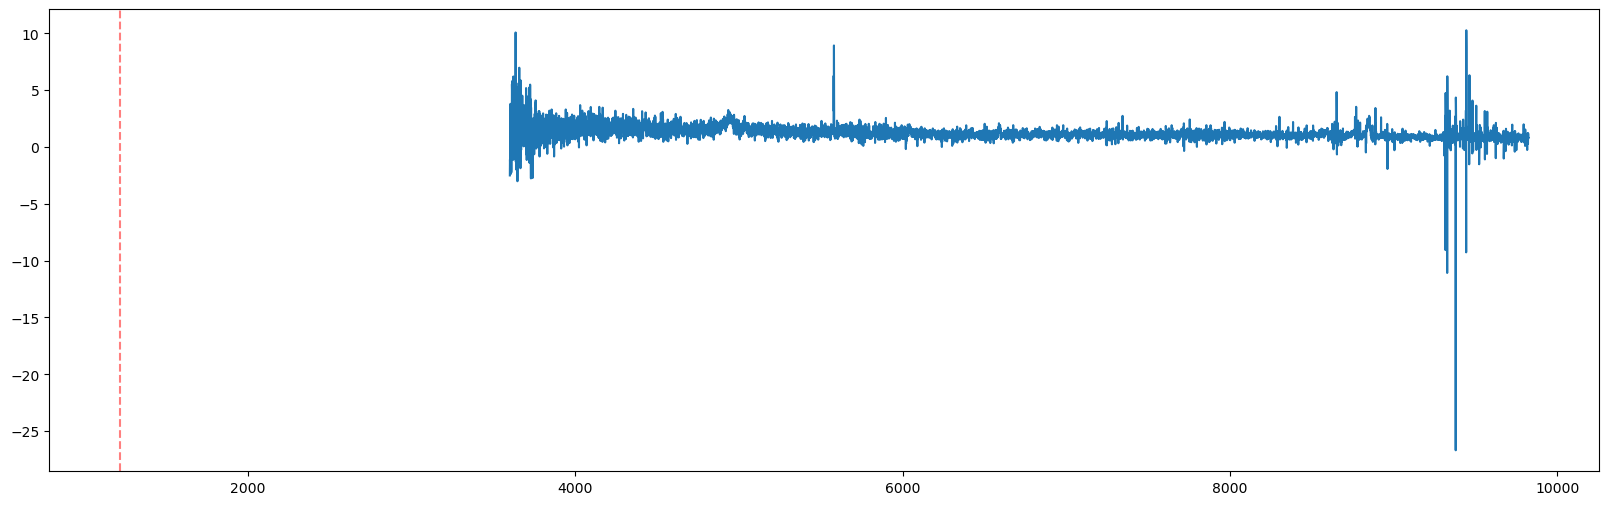

In [5]:
import matplotlib.pyplot as plt
Flux = fluxes[i]
plt.figure(figsize = (20,6))
r = 1215.67 * (1 + elg_redshift[i])
plt.axvline(r, color = 'red', linestyle = '--', alpha=0.5)

wavelength_min = 3600  # in AA
wavelength_max = 9824.  # in AA

# Create an array of 7781 linearly spaced values within this range
pixels = np.linspace(wavelength_min, wavelength_max, 7781)



plt.plot(pixels, fluxes[i])
#plt.plot(pixels, 1/np.sqrt(ivar[i]))


In [14]:
r

7968.888119499714